# 最终修订版量化回测框架

## 核心逻辑修订 (根据最新反馈):
1.  **交易事件流与头寸轧差 (Commission Netting):**
    - **核心思想:** 为了解决重叠交易在同一时间点平仓导致手续费重复计算的问题，回测逻辑被重构。
    - **实现方式:**
        - 每个交易信号 (`T-1`时刻) 会生成一个 **开仓事件** (`T`时刻) 和一个 **计划平仓事件** (`T+10`时刻)。
        - 将所有事件按时间点聚合，计算出每个时间点的 **净头寸变化**。
        - **手续费仅基于净头寸变化的绝对值计算**。如果一个多头平仓和一个空头平仓在同一时刻发生，它们的净头寸变化为0，因此不产生平仓手续费。
2.  **损益计算分离:**
    - **毛利 (Gross PnL):** 单独计算每个完整交易（从开仓到平仓）不考虑手续费的原始损益。
    - **成本 (Costs):** 基于上述的净头寸变化独立计算每日总手续费。
    - **净利 (Net PnL):** `每日净利 = 每日毛利 - 每日成本`。
3.  **单利计算:** 最终的权益曲线仍基于每日净损益的累加（单利模式），符合之前的要求。
4.  **数据源:** 脚本继续使用导师提供的 `_test_backtest_intern.pkl` 数据。

In [11]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from pathlib import Path

---
## 1. 日志和绘图设置

In [12]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # Use a visually appealing plotting style

---
## 2. 核心回测与评估函数 (源于您的代码)

In [13]:
def run_backtest_with_commission_netting(prices, signals, holding_period=10, initial_capital=100000, commission_rate=0.0002):
    """
    执行基于交易事件流和手续费轧差的向量化回测。

    此逻辑精确处理重叠交易的成本问题:
    - 每个信号产生一个开仓事件和一个计划平仓事件。
    - 在每个时间点，所有事件被聚合以计算净头寸变化。
    - 手续费仅根据净头寸变化的绝对值计算，从而自动对冲掉方向相反的同期平仓。
    - 损益以单利模式累计。

    参数:
    - prices (pd.Series): 'close' 价格序列。
    - signals (pd.Series): 交易信号 (1 for long, -1 for short, 0 for neutral)。
    - holding_period (int): 持仓周期。
    - initial_capital (float): 初始资金。
    - commission_rate (float): 单边交易手续费率。

    返回:
    - pd.DataFrame: 包含详细回测结果的DataFrame。
    - pd.DataFrame: 包含所有独立完整交易明细的DataFrame。
    """
    logging.info(f"🤔 开始执行回测 (持仓周期: {holding_period}, 采用手续费轧差逻辑)...")

    # --- 1. 数据准备 ---
    df = pd.DataFrame({'close': prices, 'signal': signals}).sort_index()
    df['market_return'] = df['close'].pct_change()

    # --- 2. 生成所有独立的交易事件 (开仓/平仓) ---
    trade_events = []
    # 信号在 t-1 时刻产生，交易在 t 时刻执行
    trade_triggers = df['signal'].shift(1)
    entry_signals = trade_triggers[trade_triggers != 0]

    logging.info(f"发现 {len(entry_signals)} 个潜在的交易信号。")

    # --- 3. 生成完整的交易列表 (用于计算毛利) 和交易事件列表 (用于计算成本) ---
    full_trades_list = []
    for entry_time, direction in entry_signals.items():
        try:
            entry_idx = df.index.get_loc(entry_time)
            exit_idx = entry_idx + holding_period

            if exit_idx < len(df.index):
                exit_time = df.index[exit_idx]
                entry_price = df.loc[entry_time, 'close']
                exit_price = df.loc[exit_time, 'close']

                # 计算单笔交易的毛利 (不含手续费)
                gross_return = direction * ((exit_price / entry_price) - 1)

                # 记录完整的交易信息 (用于后续分析和毛利计算)
                full_trades_list.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'direction': direction,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'gross_return': gross_return
                })

                # 生成开仓事件
                trade_events.append({'timestamp': entry_time, 'direction': direction})
                # 生成计划平仓事件
                trade_events.append({'timestamp': exit_time, 'direction': -direction})

        except KeyError:
            logging.warning(f"无法在索引中找到进入时间 {entry_time}。跳过此交易。")
            continue
    
    if not full_trades_list:
        logging.error("❌ 未能成功生成任何交易。无法继续。")
        return pd.DataFrame(), pd.DataFrame()

    trades_df = pd.DataFrame(full_trades_list)
    events_df = pd.DataFrame(trade_events)
    logging.info(f"成功生成 {len(trades_df)} 笔完整交易 和 {len(events_df)} 个交易事件。")

    # --- 4. 计算每日毛利 (Gross PnL) ---
    # 按平仓时间对毛利进行分组求和
    gross_pnl_by_exit_time = trades_df.groupby('exit_time')['gross_return'].sum()
    daily_gross_pnl = pd.Series(0.0, index=df.index)
    daily_gross_pnl.update(gross_pnl_by_exit_time)

    # --- 5. 计算每日交易成本 (基于轧差后的净头寸变化) ---
    # 按时间戳聚合所有事件，计算净头寸变化
    net_position_change = events_df.groupby('timestamp')['direction'].sum()
    # 交易量是净头寸变化的绝对值
    trade_volume = net_position_change.abs()
    # 每日成本 = 交易量 * 手续费率
    daily_costs = trade_volume * commission_rate
    
    # --- 6. 计算每日净利 (Net PnL) 和权益曲线 (单利) ---
    daily_net_pnl = daily_gross_pnl - daily_costs.reindex(df.index).fillna(0)
    cumulative_pnl = daily_net_pnl.cumsum()
    equity_curve = initial_capital * (1 + cumulative_pnl)

    # --- 7. 整合最终结果 ---
    backtest_results = df.copy()
    backtest_results['daily_gross_pnl'] = daily_gross_pnl
    backtest_results['daily_costs'] = daily_costs.reindex(df.index).fillna(0)
    backtest_results['daily_net_pnl'] = daily_net_pnl
    backtest_results['cumulative_pnl'] = cumulative_pnl
    backtest_results['equity_curve'] = equity_curve
    
    # 为评估函数提供兼容列
    backtest_results['strategy_net_returns'] = daily_net_pnl
    backtest_results['market_returns'] = df['market_return']
    
    # 计算活跃头寸数量
    active_positions = net_position_change.reindex(df.index).fillna(0).cumsum()
    backtest_results['position'] = active_positions

    logging.info("🎉🎉 采用手续费轧差逻辑的回测完成。")
    return backtest_results, trades_df

In [14]:
def evaluate_performance(backtest_results, trades_df, evaluation_criteria, initial_capital):
    """
    计算并展示全面的策略性能评估报告。
    此函数与回测逻辑解耦，可适配任何生成标准回测结果格式的函数。
    """
    logging.info("🤔🤔🤔 开始进行策略性能评估...")

    if backtest_results.empty or trades_df.empty:
        logging.error("❌ 回测结果为空，无法进行评估。")
        return

    equity_curve = backtest_results['equity_curve'].dropna()
    net_returns = backtest_results['strategy_net_returns'] # 这是每日净损益因子
    market_returns = backtest_results['market_returns']
    
    # --- 1. 交易统计 (基于 trades_df 的毛利) ---
    # 注意：胜率等指标基于毛利计算，以反映策略的原始预测能力，不受手续费结构影响
    trade_returns_series = trades_df['gross_return']
    
    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    
    total_trades = len(trades_df)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1

    # --- 2. 核心指标 (基于权益曲线和净损益序列) ---
    annualization_factor = 12 # 基于月度重采样

    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1

    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0
    
    # 单利模式下的年化收益率
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    # 月度净收益率应为每日收益之和
    monthly_net_returns = net_returns.resample('M').sum().dropna()
    monthly_market_returns = (1 + market_returns).resample('M').prod() - 1
    monthly_market_returns = monthly_market_returns.dropna()

    annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor) if not monthly_net_returns.empty else 0

    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    
    end_date_idx = drawdown.idxmin() if not drawdown.empty else None
    peak_idx = equity_curve.loc[:end_date_idx].idxmax() if end_date_idx is not None else None

    sharpe_ratio = (monthly_net_returns.mean() / monthly_net_returns.std()) * np.sqrt(annualization_factor) if annualized_volatility > 0 else 0
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    downside_std = downside_monthly_returns.std() if not downside_monthly_returns.empty else 0
    sortino_ratio = (monthly_net_returns.mean() / downside_std) * np.sqrt(annualization_factor) if downside_std > 0 else 0

    average_win_gross = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss_gross = abs(losing_trades_pnl.mean()) if num_losing_trades > 0 else 0
    
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    annual_returns = net_returns.resample('Y').sum()
    annual_returns.index = annual_returns.index.year

    # --- 3. 其他指标 ---
    total_weeks = total_days / 7.0 if total_days > 0 else 1
    weekly_trade_frequency = total_trades / total_weeks if total_weeks > 0 else 0

    # 年化换手率 = 年化交易次数 / 平均活跃头寸
    avg_active_positions = backtest_results['position'][backtest_results['position'] > 0].mean()
    annualized_turnover = (total_trades / duration_years) / avg_active_positions if duration_years > 0 and avg_active_positions > 0 else 0

    # --- 4. 打印评估报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("="*80)
    
    def format_check(name, value, req_value, req_prefix, comp_func):
        is_ok = comp_func(value, req_value)
        status = "✅ 通过" if is_ok else "❌ 未通过"
        req_str = f"{req_prefix} {req_value:.2f}"
        color = Fore.GREEN if is_ok else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    headers = ["指标", "结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, evaluation_criteria['sharpe_ratio'], ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, evaluation_criteria['calmar_ratio'], ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, evaluation_criteria['expectancy'], ">", lambda v, r: v > r)
    ]
    print("\n" + Fore.BLUE + Style.BRIGHT + "--- 盈利能力指标 ---" + Style.RESET_ALL)
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center"))

    risk_table = [
        format_check("最大回撤 (MDD)", max_drawdown, evaluation_criteria['max_drawdown'], "<", lambda v, r: v < r),
        format_check("周均开仓频率", weekly_trade_frequency, evaluation_criteria['weekly_frequency'], ">", lambda v, r: v > r)
    ]
    print("\n" + Fore.YELLOW + Style.BRIGHT + "--- 风险与效率指标 ---" + Style.RESET_ALL)
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center"))

    print("\n" + Fore.GREEN + Style.BRIGHT + "--- 详细统计数据 ---" + Style.RESET_ALL)
    detail_headers = ["指标", "数值"]
    detail_table = [
        ["总回报率", f"{total_return:.2%}"],
        ["年化回报率 (单利)", f"{annualized_return:.2%}"],
        ["年化波动率", f"{annualized_volatility:.2%}"],
        ["索提诺比率 (Sortino)", f"{sortino_ratio:.4f}"],
        ["总净盈亏", f"{total_pnl_amount:,.2f}"],
        ["总交易次数", f"{total_trades}"],
        ["胜率 (基于毛利)", f"{win_rate:.2%}"],
        ["盈亏比 (基于毛利)", f"{profit_loss_ratio:.2f}"],
        ["平均毛盈利", f"{average_win_gross:.4%}"],
        ["平均毛亏损", f"{average_loss_gross:.4%}"],
        ["年化换手率", f"{annualized_turnover:.2f}"],
        ["最大回撤起始日期", str(peak_idx.date()) if peak_idx else "N/A"],
        ["最大回撤结束日期", str(end_date_idx.date()) if end_date_idx else "N/A"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center"))

    print("\n" + Fore.MAGENTA + Style.BRIGHT + "--- 年度回报率 (单利) ---" + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index()
    annual_returns_df.columns = ["年份", "回报率"]
    annual_returns_df["回报率"] = annual_returns_df["回报率"].apply(lambda x: f"{x:.2%}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    # --- 5. 绘制权益曲线 ---
    fig, ax1 = plt.subplots(figsize=(20, 10))
    
    equity_curve.plot(label='策略权益曲线 (单利, 轧差成本)', lw=2, color='royalblue', ax=ax1)
    
    benchmark_equity = initial_capital * (1 + market_returns.cumsum())
    benchmark_equity.plot(label='买入并持有 (Buy & Hold)', lw=2, linestyle='--', color='darkorange', ax=ax1)

    ax1.set_title('策略 vs. 基准权益曲线', fontsize=16)
    ax1.set_ylabel('权益', fontsize=12)
    ax1.set_xlabel('日期', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    logging.info("🎊🎊🎊 策略评估完成 🎊🎊🎊")

---
## 3. 主程序执行

2025-07-24 13:03:02,557 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-24 13:03:02,559 - INFO - ✅ 数据加载成功。
2025-07-24 13:03:02,559 - INFO - 数据维度: (131808, 2)
2025-07-24 13:03:02,559 - INFO - 时间范围: 2021-09-27 00:00:00 到 2025-06-30 23:45:00
2025-07-24 13:03:02,560 - INFO - 🤔 开始执行回测 (持仓周期: 10, 采用手续费轧差逻辑)...
2025-07-24 13:03:02,564 - INFO - 发现 26862 个潜在的交易信号。
2025-07-24 13:03:03,446 - INFO - 成功生成 26858 笔完整交易 和 53716 个交易事件。
2025-07-24 13:03:03,473 - INFO - 🎉🎉 采用手续费轧差逻辑的回测完成。
2025-07-24 13:03:03,483 - INFO - 🤔🤔🤔 开始进行策略性能评估...



                            导师理智检查                            
累计【净】收益 与 累计【毛】收益 的相关性: -0.05837522
❌ 相关性异常。请检查毛利和成本的计算逻辑。


                              策略性能评估报告                              

--- 盈利能力指标 ---
+-----------------------+---------+--------+-----------+
|         指标          |    结果 |  要求  |   状态    |
+=======================+=========+========+===========+
|   夏普比率 (Sharpe)   | -0.5547 | > 1.00 | ❌ 未通过 |
+-----------------------+---------+--------+-----------+
|   卡玛比率 (Calmar)   | -0.1623 | > 1.00 | ❌ 未通过 |
+-----------------------+---------+--------+-----------+
| 期望收益 (Expectancy) |  0.0491 | > 0.25 | ❌ 未通过 |
+-----------------------+---------+--------+-----------+

--- 风险与效率指标 ---
+----------------+----------+--------+-----------+
|      指标      |     结果 |  要求  |   状态    |
+================+==========+========+===========+
| 最大回撤 (MDD) |   5.6686 | < 0.30 | ❌ 未通过 |
+----------------+----------+--------+-----------+
|  周均开仓频率  | 137.031  | > 5.00 |  ✅ 通过  |
+----------

/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2929307/3806403846.py:151: UserWarning: Glyph 22522 (\N

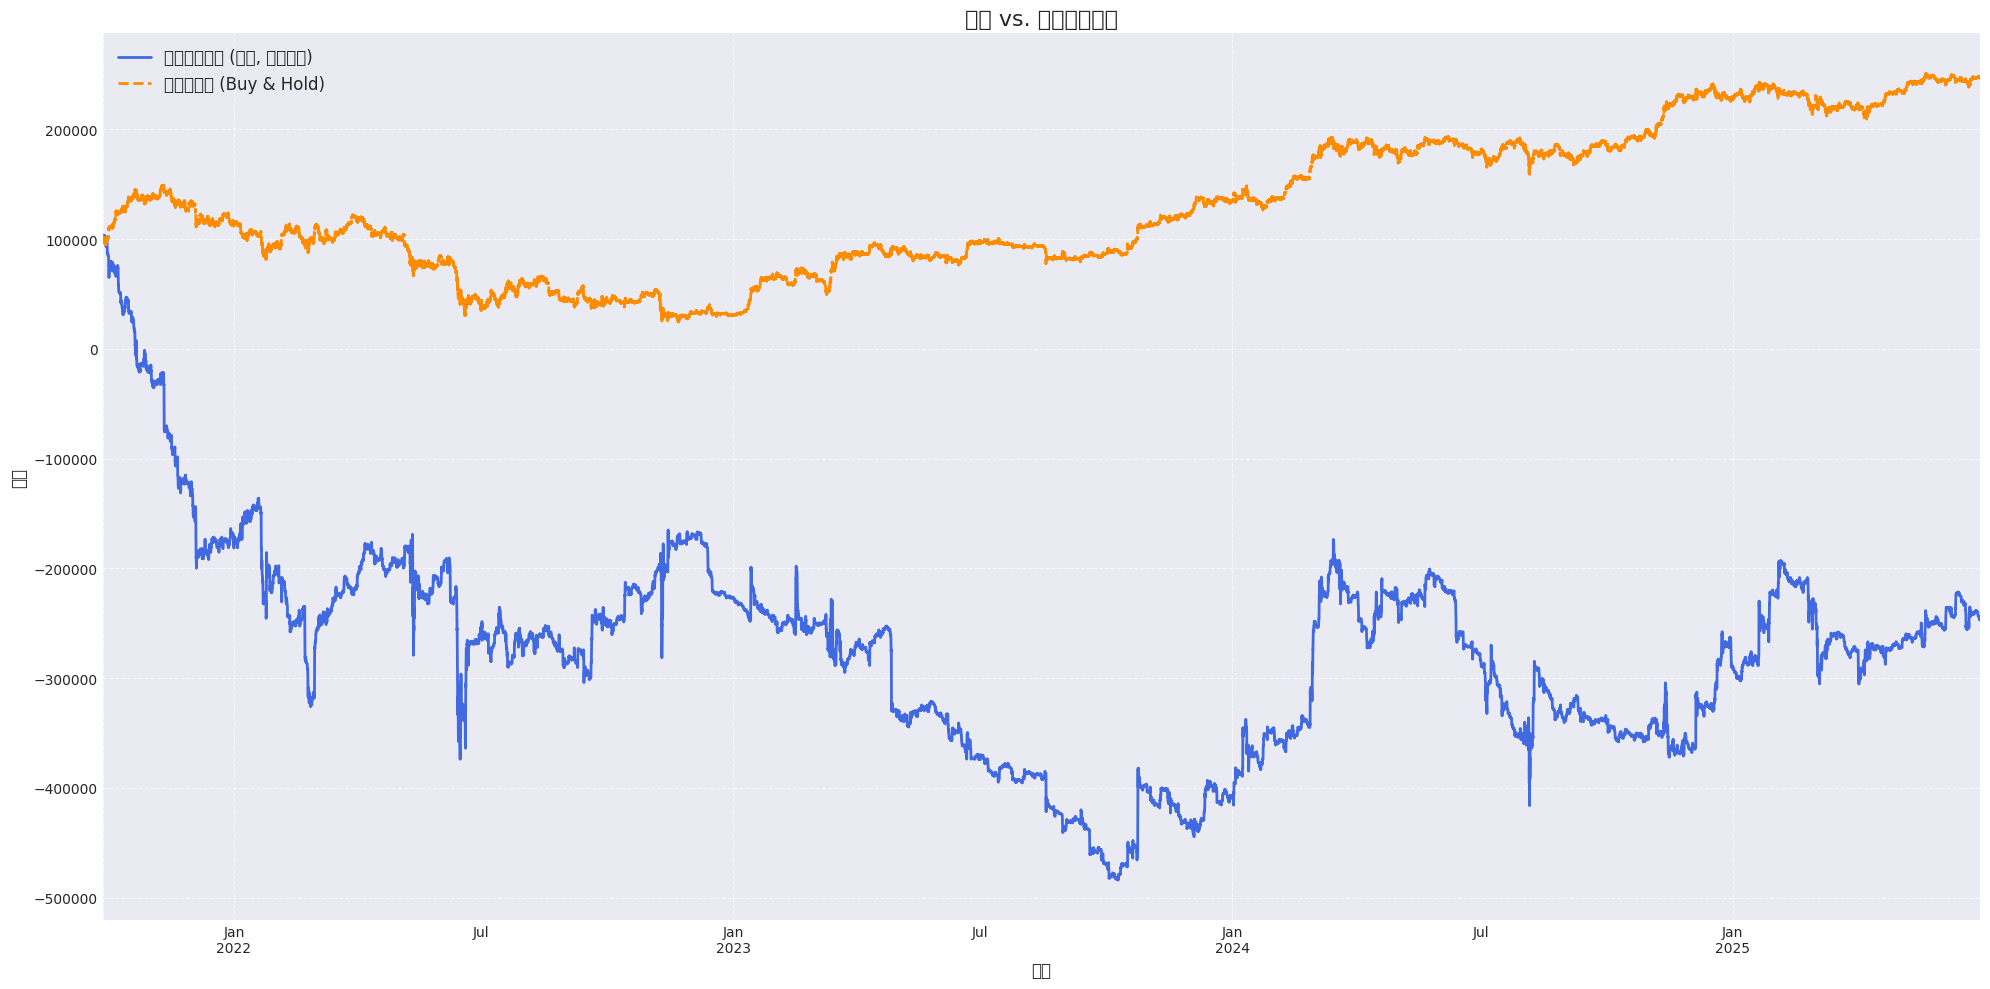

2025-07-24 13:03:06,217 - INFO - 🎊🎊🎊 策略评估完成 🎊🎊🎊


In [15]:
if __name__ == '__main__':
    # --- 参数配置 ---
    FILE_PATH = Path("/public/data/_test_backtest_intern.pkl")
    
    # 回测参数
    HOLDING_PERIOD = 10         # 持仓 10 个周期 (10 * 15 分钟)
    COMMISSION_RATE = 0.0002    # 单边手续费
    INITIAL_CAPITAL = 100000    # 初始资金
    
    # 策略评估标准
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 1.0,
        'calmar_ratio': 1.0,
        'expectancy': 0.25,
        'max_drawdown': 0.30, # 30%
        'weekly_frequency': 5
    }

    # --- 步骤 1: 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    if not FILE_PATH.exists():
        logging.error(f"❌ 致命错误: 在 {FILE_PATH} 未找到数据文件。请检查路径。")
    else:
        data = pd.read_pickle(FILE_PATH)
        logging.info("✅ 数据加载成功。")
        logging.info(f"数据维度: {data.shape}")
        logging.info(f"时间范围: {data.index.min()} 到 {data.index.max()}")
        
        # --- 步骤 2: 执行回测 ---
        backtest_results, trades_df = run_backtest_with_commission_netting(
            prices=data['close'],
            signals=data['signal'],
            holding_period=HOLDING_PERIOD,
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE
        )
        
        if not backtest_results.empty:
            # --- 【重要】导师理智检查 (相关性检验) ---
            print("\n" + "="*80)
            print(Fore.BLUE + Style.BRIGHT + " " * 28 + "导师理智检查" + " " * 28 + Style.RESET_ALL)
            print("="*80)

            # 1. 获取策略的累计净收益 (已包含轧差成本)
            strategy_cumulative_net_pnl = backtest_results['cumulative_pnl'].fillna(0)

            # 2. 计算理论上的累计毛收益 (不含任何成本)
            cumulative_gross_pnl = backtest_results['daily_gross_pnl'].cumsum()

            # 3. 对齐索引并计算相关性
            aligned_net, aligned_gross = strategy_cumulative_net_pnl.align(cumulative_gross_pnl, join='inner', fill_value=0)
            
            correlation = 0.0
            if not aligned_net.empty and not aligned_gross.empty and aligned_net.std() > 0 and aligned_gross.std() > 0:
                correlation = aligned_net.corr(aligned_gross)

            print(f"累计【净】收益 与 累计【毛】收益 的相关性: {correlation:.8f}")
            if correlation < 1.0 and correlation > 0.8:
                print(Fore.GREEN + "✅ 相关性符合预期。净收益曲线是毛收益曲线扣除成本后的结果。" + Style.RESET_ALL)
            else:
                print(Fore.RED + "❌ 相关性异常。请检查毛利和成本的计算逻辑。" + Style.RESET_ALL)
            print("="*80 + "\n")

            # --- 步骤 3: 性能评估 ---
            evaluate_performance(
                backtest_results,
                trades_df,
                EVALUATION_CRITERIA,
                INITIAL_CAPITAL
            )